In [2]:
# Import Libraries
import pandas as pd
import string, contractions
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [3]:
# Import Data
reviews_data_set_path = "/Users/swapnakotha/Desktop/CMPE-257/yelp_dataset/yelp_academic_dataset_review.json"
business_data_set_path = "/Users/swapnakotha/Desktop/CMPE-257/yelp_dataset/yelp_academic_dataset_business.json"


# Dataset is very large(it contains around 6 million reviews). For this analysis, we will only consider the businesses
# in California.

# Get list of businesses in CA.
yelp_businesses = pd.read_json(business_data_set_path, lines=True)
yelp_businesses = pd.DataFrame(yelp_businesses)
yelp_businesses = yelp_businesses.dropna()
yelp_restaurants = yelp_businesses[yelp_businesses['categories'].str.contains("Restaurants")]
yelp_restaurants = yelp_restaurants[['business_id', 'state']]
print(yelp_restaurants.shape[0])

#yelp_ca_restaurants = yelp_restaurants[yelp_restaurants.state == "CA"]
yelp_ca_restaurants = yelp_restaurants
print(yelp_ca_restaurants.shape[0])

44676
44676


In [4]:
# Load all reviews from json
chunk_size = 1000000
yelp_review_chunks = pd.read_json(reviews_data_set_path, lines=True,
                      dtype={'review_id':str,'user_id':str,
                             'business_id':str,'stars':int,
                             'date':str,'text':str,'useful':int,
                             'funny':int,'cool':int},
                      chunksize=chunk_size)

In [5]:
ca_reviews_list = []
count = 0
for review_chunk in yelp_review_chunks:
    review_chunk = review_chunk.drop(['review_id','user_id','date','useful','funny','cool'], axis=1)
    review_chunk = review_chunk.rename(columns={'stars': 'review_stars'})
    review_chunk = review_chunk.rename(columns={'text': 'review_text'})
    #Merge reviews which corresponds to the business in CA.
    ca_review_chunk = pd.merge(yelp_ca_restaurants, review_chunk, on='business_id', how='inner')
    print(f"{ca_review_chunk.shape[0]} out of {chunk_size:,} reviews")
    ca_reviews_list.append(ca_review_chunk)
    count += ca_review_chunk.shape[0]
    # Taking a subset as processing time is very high.
    if count > 1000000:
        break

ca_reviews_df = pd.concat(ca_reviews_list, ignore_index=True, join='outer', axis=0)

666171 out of 1,000,000 reviews
656541 out of 1,000,000 reviews


In [6]:
ca_reviews_df.head()

,business_id,state,review_stars,review_text
0,MTSW4McQd7CbVtyjqoe9mw,PA,4,This is nice little Chinese bakery in the hear...
1,MTSW4McQd7CbVtyjqoe9mw,PA,4,This is the bakery I usually go to in Chinatow...
2,MTSW4McQd7CbVtyjqoe9mw,PA,5,"A delightful find in Chinatown! Very clean, an..."
3,MTSW4McQd7CbVtyjqoe9mw,PA,5,I ordered a graduation cake for my niece and i...
4,MTSW4McQd7CbVtyjqoe9mw,PA,4,HK-STYLE MILK TEA: FOUR STARS\n\nNot quite su...


In [7]:
ca_reviews_df = ca_reviews_df[['review_text', 'review_stars']]
ca_reviews_df.head()

,review_text,review_stars
0,This is nice little Chinese bakery in the hear...,4
1,This is the bakery I usually go to in Chinatow...,4
2,"A delightful find in Chinatown! Very clean, an...",5
3,I ordered a graduation cake for my niece and i...,5
4,HK-STYLE MILK TEA: FOUR STARS\n\nNot quite su...,4


In [8]:
ca_reviews_df.isna().mean()

review_text     0.0
review_stars    0.0
dtype: float64

In [10]:
ca_reviews_df = ca_reviews_df.head(1000000)

In [11]:
print(ca_reviews_df.shape[0])

1000000


In [12]:
# Assign labels to each review. Positive as 2, Neutral as 1, Negative as 0.
#ca_reviews_df['review_labels'] = ca_reviews_df['review_stars'].apply(lambda x:0 if x<3 else (1 if x==3 else 2))

# Assign labels to each review. Positive as 1, Negative as 0.
ca_reviews_df['review_binary_labels'] = ca_reviews_df['review_stars'].apply(lambda x:0 if x<3 else 1)

ca_reviews_df.head()

,review_text,review_stars,review_binary_labels
0,This is nice little Chinese bakery in the hear...,4,1
1,This is the bakery I usually go to in Chinatow...,4,1
2,"A delightful find in Chinatown! Very clean, an...",5,1
3,I ordered a graduation cake for my niece and i...,5,1
4,HK-STYLE MILK TEA: FOUR STARS\n\nNot quite su...,4,1


In [13]:
# Create training data set & test data set from dataframe
def get_training_and_test_data(ca_reviews_df, label):
    reviews_training_data, reviews_test_data = train_test_split(ca_reviews_df, test_size = 0.3, stratify = ca_reviews_df[label], random_state = 42)
    y_reviews_training_labels = reviews_training_data[label].values
    y_reviews_test_labels = reviews_test_data[label].values
    return reviews_training_data, y_reviews_training_labels, reviews_test_data, y_reviews_test_labels

def pre_process_review(review):
    tokens = []
    
    # lower case the review string
    review = review.lower()
    
    # split the review into individual tokens
    review_token_list = review.split()
    
    # Removing contractions and punctuation from token
    for review_token in review_token_list:
        review_token = contractions.fix(review_token)
        review_token = review_token.translate(str.maketrans('','',string.punctuation))
        for token in review_token.split():
            tokens.append(token)

    return tokens


In [14]:
# Perform Analysis with 2 labels (Positive or Negative) with in-built analyzer

reviews_training_data, y_reviews_training_labels, reviews_test_data, y_reviews_test_labels = get_training_and_test_data(ca_reviews_df, 'review_binary_labels')

# Perform Vectorization on the review text
vectorize_reviews = CountVectorizer(binary=True, min_df = 10, max_df = 0.95, ngram_range=(1,2))
vectorize_reviews.fit_transform(reviews_training_data['review_text'].values)

reviews_training_features = vectorize_reviews.transform(reviews_training_data['review_text'].values)
reviews_test_features = vectorize_reviews.transform(reviews_test_data['review_text'].values)

In [15]:
# Run Logistic Regression
logistic_regression = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
logistic_regression.fit(reviews_training_features,y_reviews_training_labels)
y_reviews_predicted_labels = logistic_regression.predict(reviews_test_features)

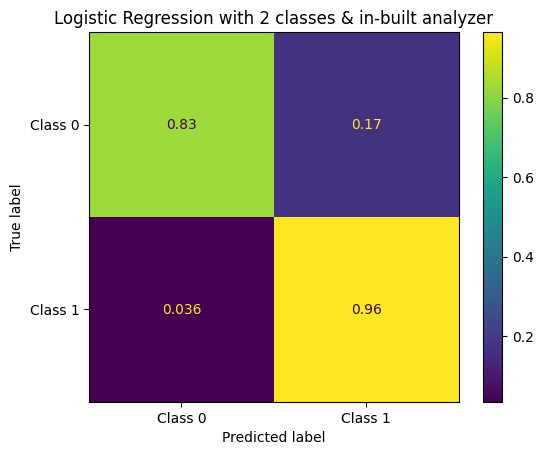

Accuracy:  0.937
F1:  0.937


In [16]:
disp = ConfusionMatrixDisplay.from_predictions(y_reviews_test_labels, y_reviews_predicted_labels,
                                               normalize='true',
                                               display_labels=['Class 0', 'Class 1'])
disp.ax_.set_title('Logistic Regression with 2 classes & in-built analyzer');
plt.show()

# Calculate Accuracy & F1 Score
print("Accuracy: ",round(metrics.accuracy_score(y_reviews_test_labels,y_reviews_predicted_labels),3))
print("F1: ",round(metrics.f1_score(y_reviews_test_labels, y_reviews_predicted_labels, average='weighted'),3))

In [40]:
test_review = vectorize_reviews.transform(["Super slow service,salads are not good"])
output=logistic_regression.predict_proba(test_review)

negative=round(output[0][0],3)
positive=round(output[0][1],3)
print("Proability that test review is positive is "+ str(positive))
print("Proability that test review is negative is "+ str(negative))

Proability that test review is positive is 0.134
Proability that test review is negative is 0.866


In [43]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
test_review1 = vectorize_reviews.transform(["Super slow service,salads are not good."])
output1=loaded_model.predict_proba(test_review)
negative1=round(output[0][0],3)
positive1=round(output[0][1],3)
print("Proability that test review is positive is "+ str(positive1))
print("Proability that test review is negative is "+ str(negative1))

Proability that test review is positive is 0.134
Proability that test review is negative is 0.866


In [ ]:
import pickle
filename = 'finalized_model_logistic _regression.sav'
pickle.dump(logistic_regression, open(filename, 'wb'))